In [49]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from backtest_functions_v2 import *

In [33]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v1.parquet")

### Create 3-class prediction target

In [34]:
# Create 3-class target:
df['target'] = np.where(df['return_forward'] > 0.001, 2,
                        np.where(df['return_forward'] < -0.001, 0, 1))

print("Target class distribution:")
print(df['target'].value_counts())

Target class distribution:
target
2    13105
0    12641
1     9312
Name: count, dtype: int64


### Spliting dataset

In [35]:
# list of features column names
all_features = df.columns.drop(['target', 'return_forward'])

In [36]:
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


In [37]:
df.shape

(35058, 141)

Overall Annual Return: 29.0%
Overall Annual Sharpe Ratio: 0.9281
Maximum Drawdown: -39.58 %
Alpha: 0.0578
Beta: 0.5139

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.580840    0.473035     0.537757      0.127605       1.204715
1  2022      -0.266809    0.279458     0.425057      0.072442      -0.970859
2  2023       0.568850    0.216655     0.501024     -0.044743       2.186980
3  2024       0.522268    0.315245     0.588376     -0.077794       1.490642


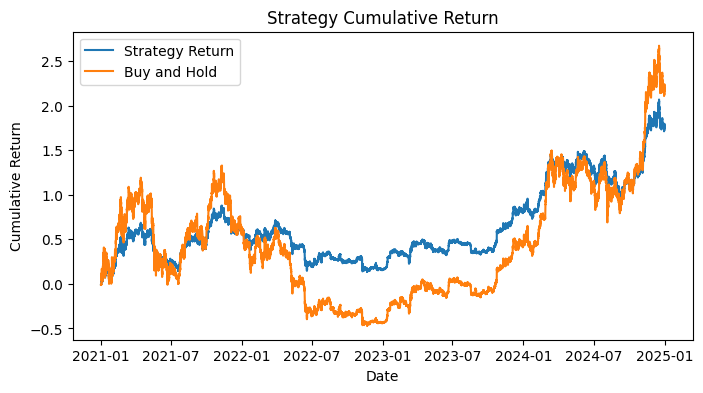

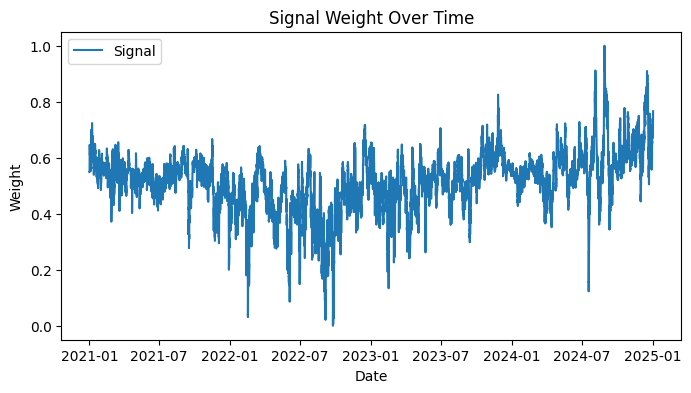

In [58]:
selected_features = [
  'tanalysis_absa_ewm_12h', 'tanalysis_absa_ewm_70h', 'economy_absa_ewm_12h',
  'economy_absa_ewm_70h', 'regulation_absa_ewm_12h', 'regulation_absa_ewm_70h',
  'technology_absa_ewm_12h', 'technology_absa_ewm_70h', 'adoption_absa_ewm_12h',
  'adoption_absa_ewm_70h'
]

selected_features = [
  'tanalysis_absa_ewm_12h', 'economy_absa_ewm_12h',
  'regulation_absa_ewm_12h', 'technology_absa_ewm_12h',
  'adoption_absa_ewm_12h'
]

# df['signal'] = mean of selected features
df['signal'] = df[selected_features].mean(axis=1)

################################

df['signal'] = df['economy_absa_ewm_70h']

# apply min max scaler to signal
scaler = MinMaxScaler()
df['signal'] = scaler.fit_transform(df[['signal']])

run_backtest(df, 'h')

### Model (logistic regression)

In [38]:
# Manual feature selection
selected_features = [
  'tanalysis_absa_ewm_12h', 'tanalysis_absa_ewm_70h', 'economy_absa_ewm_12h',
  'economy_absa_ewm_70h', 'regulation_absa_ewm_12h', 'regulation_absa_ewm_70h',
  'technology_absa_ewm_12h', 'technology_absa_ewm_70h', 'adoption_absa_ewm_12h',
  'adoption_absa_ewm_70h'
]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [39]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('logreg', LogisticRegression(solver='saga', random_state=42, class_weight='balanced', max_iter=8000))
])

# Parameter grid for GridSearchCV
param_grid = {
  'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
  'logreg__penalty': ['l1']
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
start_time = time.time()
grid_search.fit(X_train_selected, y_train)
end_time = time.time()

print(f"GridSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Get the best estimator
best_model = grid_search.best_estimator_

GridSearchCV fitting time: 21.75 seconds
Best parameters found:  {'logreg__C': 0.01, 'logreg__penalty': 'l1'}
Best cross-validation accuracy:  0.3256451244576387


In [40]:
# Make predictions on the test set
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# For multiclass ROC AUC, specify multi_class='ovr' or 'ovo' and provide probabilities
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Test Set Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"\nROC AUC Score (One-vs-Rest): {roc_auc:.4f}")

Test Set Accuracy: 0.3461

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.09      0.15      2648
           1       0.37      0.53      0.43      3274
           2       0.31      0.37      0.34      2862

    accuracy                           0.35      8784
   macro avg       0.35      0.33      0.31      8784
weighted avg       0.35      0.35      0.32      8784


Confusion Matrix:
[[ 251 1432  965]
 [ 179 1733 1362]
 [ 269 1537 1056]]

ROC AUC Score (One-vs-Rest): 0.5025


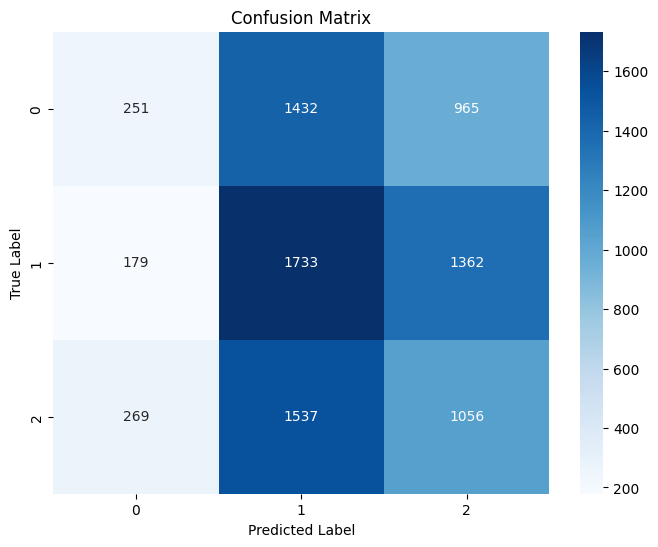

In [41]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Model Coefficients:
                          Class 0   Class 1  Class 2
tanalysis_absa_ewm_12h   0.000000  0.000000      0.0
tanalysis_absa_ewm_70h  -0.050016  0.075220      0.0
economy_absa_ewm_12h     0.000000  0.020395      0.0
economy_absa_ewm_70h     0.000000  0.000000      0.0
regulation_absa_ewm_12h  0.000000  0.000000      0.0
regulation_absa_ewm_70h  0.000000  0.307184      0.0
technology_absa_ewm_12h  0.000000 -0.015794      0.0
technology_absa_ewm_70h  0.000000  0.091533      0.0
adoption_absa_ewm_12h    0.000000  0.000000      0.0
adoption_absa_ewm_70h    0.000000 -0.274082      0.0


<Figure size 1000x600 with 0 Axes>

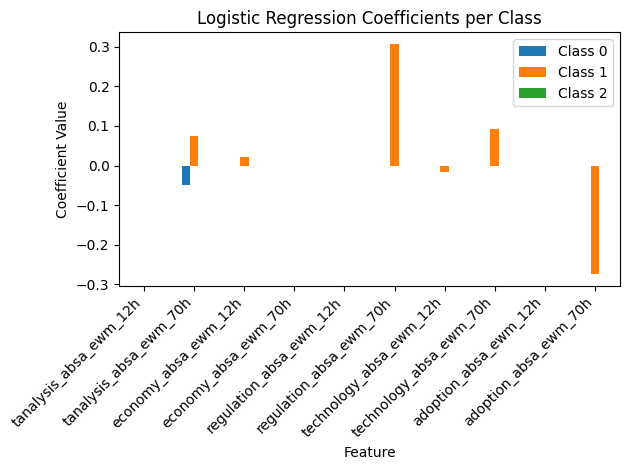

In [42]:
# Get the coefficients from the logistic regression model within the pipeline
coefficients = best_model.named_steps['logreg'].coef_

# Create a DataFrame to display coefficients for each class
coef_df = pd.DataFrame(coefficients, columns=selected_features, index=['Class 0', 'Class 1', 'Class 2'])

print("Model Coefficients:")
# Transpose for better readability if there are many features
print(coef_df.T)

# Optionally, plot the coefficients for visualization
plt.figure(figsize=(10, 6))
coef_df.T.plot(kind='bar')
plt.title('Logistic Regression Coefficients per Class')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

----------------

In [43]:
columns = df.columns.tolist()
for i in range(0, len(columns), 5):
  print(columns[i:i+5])

['news_count', 'return_forward', 'sma_5_20_diff', 'sma_20_50_diff', 'sma_50_200_diff']
['ema_5_20_diff', 'ema_20_50_diff', 'ema_50_200_diff', 'sma_5_20_diff_abs_chg', 'sma_5_20_diff_pct_chg']
['sma_20_50_diff_abs_chg', 'sma_20_50_diff_pct_chg', 'sma_50_200_diff_abs_chg', 'sma_50_200_diff_pct_chg', 'ema_5_20_diff_abs_chg']
['ema_5_20_diff_pct_chg', 'ema_20_50_diff_abs_chg', 'ema_20_50_diff_pct_chg', 'ema_50_200_diff_abs_chg', 'ema_50_200_diff_pct_chg']
['macd_12_26', 'signal_line_9', 'macd_histogram', 'macd_position', 'macd_crossover']
['adx', '+di', '-di', 'adx_slope', 'adx_strength']
['di_crossover', 'di_spread', 'adx_di_composite', 'rsi_7', 'rsi_14']
['rsi_7_slope', 'rsi_7_chg', 'rsi_7_acceleration', 'rsi_14_slope', 'rsi_14_chg']
['rsi_14_acceleration', 'rsi_ratio', 'atr_7', 'atr_14', 'atr_7_slope']
['atr_7_chg', 'atr_14_slope', 'atr_14_chg', 'norm_price_change_7', 'norm_price_change_14']
['atr_ratio', 'trailing_stop_long_7', 'trailing_stop_long_14', 'trailing_stop_short_7', 'trailin

Overall Annual Return: 3.05%
Overall Annual Sharpe Ratio: 1.0254
Maximum Drawdown: -3.85 %
Alpha: 0.0364
Beta: -0.0106

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.064727    0.046279    -0.026378      0.085482       1.378354
1  2022      -0.006635    0.018900    -0.009788     -0.014395      -0.342783
2  2023       0.016443    0.025448     0.001973      0.014592       0.653613
3  2024       0.048860    0.019674     0.023179      0.026321       2.434529


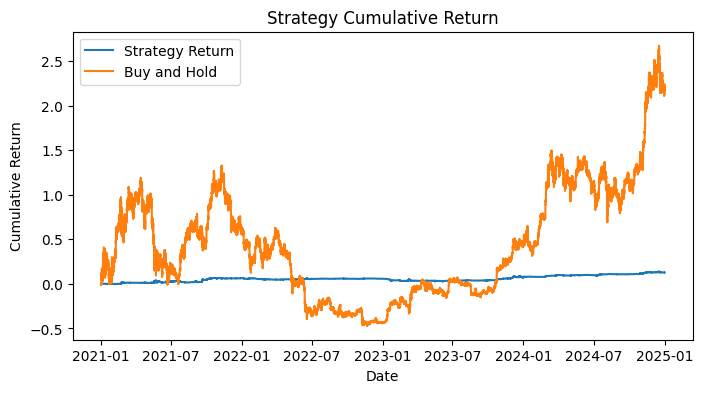

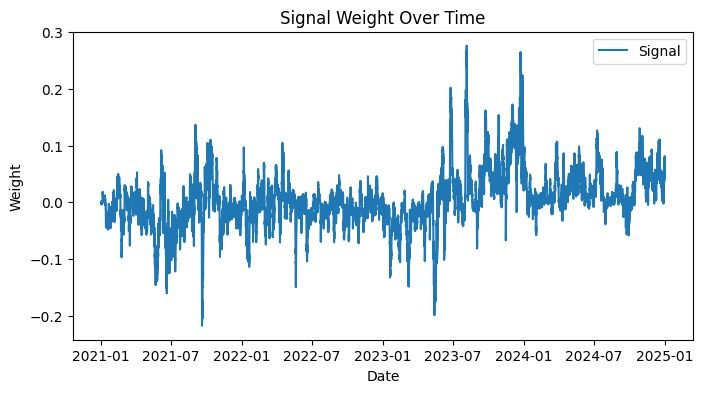

In [44]:
df['signal'] = df['regulation_absa_ewm_70h']

run_backtest(df, 'h')